# Text Classification in Cross-Validation using Convolutional Neural Network

## Import Libraries

In [56]:
import re
import time
import torch
import random
import numpy as np
import unicodedata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from lime import lime_text
from torch import nn, optim
from sklearn import metrics
from string import punctuation
from sklearn import preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

## Set Hyparameters

### Dataset Language Setting

In [57]:
language="italian"

language_w="../input/fasttext-aligned-word-vectors/wiki.it.align.vec"

### Model Parameters

In [58]:
batch_size = 128
number_of_filters = 100
filter_sizes = [1,2,3]
dropout_pc = 0.5
n_epochs = 100
patience=5
lr = 1e-3

nfold=10

### Dataset Parameters

In [59]:
path_db="../input/ciao9cci/politica.xlsx"
df = pd.read_excel(path_db, sheet_name="Foglio1")

text="testo"
review="cap_maj_master"

n_top_class=35

## Enable GPU

In [60]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 2019
#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

## Load Dataset

In [61]:
top_class=df.groupby(review).count()[[text]]
top_class=top_class.sort_values(by=[text], ascending=False).head(n_top_class)
top_class=top_class.apply(list).reset_index()
top_class = [d for d in top_class[review]]
print(top_class)

df=df.loc[df[review].isin(top_class)]
print(f'Found {len(df)} texts.')
print(f'{df[review].isnull().sum()} document(s) with no classification removed')
df=df[pd.notnull(df[review])]

df = df[df[text].str.split().str.len().gt(5)]

print(f'{df[text].isnull().sum()} document(s) with no text removed')
df=df[pd.notnull(df[text])]

le = preprocessing.LabelEncoder()
le.fit(df[review])
df[review]=le.transform(df[review])
classes = [int(c) for c in df[review].values]
documents = [d for d in df[text]]

output_dim = len(np.unique(classes))

[12.0, 10.0, 20.0, 1.0, 3.0, 15.0, 5.0, 6.0, 7.0, 19.0, 4.0, 9.0, 2.0, 16.0, 21.0, 8.0, 13.0, 17.0, 14.0, 23.0, 18.0]
Found 5672 texts.
0 document(s) with no classification removed
0 document(s) with no text removed


## Class Distribution Diagram

Number of Classes found:  21


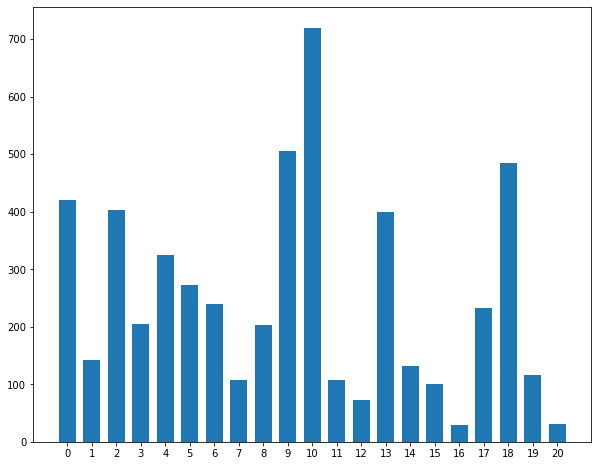

In [62]:
y = np.bincount(classes)
x = np.arange(len(y))
print("Number of Classes found: ", len(y))
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(x, y,width=0.7)
ax.set_xticks(x)
ax.set_aspect('auto')
plt.show()

## Define Preprocessor

In [63]:
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', str(text))
    #text = re.sub(r'[^\w\s]'," ", text)
    text=re.sub('\d+',' ',str(text))
    text=re.sub('[ﾫﾻ]','',str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           str(text))
    text = (re.sub('[\W]+', ' ', text.lower().strip()) + ' ' +
            ' '.join(emoticons).replace('-', ''))
    return text

def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

stop=set(stopwords.words(language))

def tokenizer(text):
    stop=set(stopwords.words(language))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop]
    filtered_sentence = [w for w in filtered_sentence if len(w)>3]
    return filtered_sentence
    
def split_words_documents(documents):
    tokenized = documents = [tokenizer(strip_accents(preprocessor(document))) 
                              for document in documents]
    all_text = []
    for tokens in tokenized:
        for t in tokens:
            all_text.append(t)
    return tokenized, set(all_text)

In [64]:
documents, vocab = split_words_documents(documents)

## Preprocessed Dataset Statistics

In [65]:
print("Max sequence length: ", np.max([len(x) for x in documents]))
print("Average sequence length: ",np.mean([len(x) for x in documents]))
quant=np.quantile([len(x) for x in documents],.75)
print("Quantile sequence length: ",quant)

Max sequence length:  1375
Average sequence length:  201.02611015818562
Quantile sequence length:  248.0


## Vocabulary Build

In [66]:
vocaboli=set(line.strip() for line in open('../input/prova2/prova.txt'))
vocaboli_more=vocaboli.union(vocab)
print("Aggiunte ",len(vocaboli_more)-len(vocaboli),"/",len(vocab)," parole")

Aggiunte  14648 / 49263  parole


In [67]:
def create_dictionaries(words):
    word_to_int_dict = {w:i+1 for i,w in enumerate(words)}
    int_to_word_dict = {i:w for w,i in word_to_int_dict.items()}
    return word_to_int_dict, int_to_word_dict
word_to_int_dict, int_to_word_dict = create_dictionaries(vocaboli)

## Define Padding

In [68]:
def pad_text(tokenized_documents,seq_length):
    documents = []
    length=[]
    for document in tokenized_documents:
        if len(document) >= seq_length:
            documents.append(document[:seq_length])
            length.append(seq_length)
        else:
            length.append(len(document))
            documents.append(document+['']*(seq_length-len(document)))
    return np.array(documents),np.array(length)

In [69]:
int_to_word_dict[0]=''
word_to_int_dict['']=0

## Pretrained Vector Loader

In [70]:
def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.double)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [71]:
# Load pretrained vectors
print("Tokenizing...\n")
embeddings = load_pretrained_vectors(word_to_int_dict, language_w)
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


871053it [00:46, 18568.48it/s]


There are 135327 / 279895 pretrained vectors found.


## Utility Functions

In [72]:
def sort_batch(X,lengths,y):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X,lengths, y 

### DataLoader Function

In [73]:
def create_data_loader(train_c,train_len, valid_c, valid_len, train_l,valid_l,batch_size):
    x_train = torch.tensor(train_c, dtype=torch.long,device=DEVICE)
    x_train_len = torch.tensor(train_len, dtype=torch.long,device=DEVICE)
    y_train = torch.tensor(train_l, dtype=torch.long, device=DEVICE)
    x_cv = torch.tensor(valid_c, dtype=torch.long, device=DEVICE)
    x_cv_len = torch.tensor(valid_len, dtype=torch.long, device=DEVICE)
    y_cv = torch.tensor(valid_l, dtype=torch.long, device=DEVICE)
    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train,x_train_len, y_train)
    valid = torch.utils.data.TensorDataset(x_cv,x_cv_len, y_cv)
    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader

### Plot Function

In [74]:
def plot_graph(train_loss, valid_loss):
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    #plt.ylim(0, 0.5) # consistent scale
    #plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### EarlyStopping Function

In [75]:
#https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Define Model


In [76]:
class ClassificationCNN(nn.Module):
    
    def __init__(self, 
                 pretrained_embedding=None,
                 freeze_embedding=True,
                 n_vocab=None, 
                 n_embed=300,
                 n_filters=100, 
                 n_output=1, 
                 filter_sizes=[2,3,4], 
                 dropout = 0.8,
                 pad_idx=0.0):
        super().__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.n_vocab, self.n_embed = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        
        
         
        self.dropout = nn.Dropout(dropout)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = self.n_embed, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) 
                                    for fs in filter_sizes
                                    ])
        
        
        self.fc1 = nn.Linear(len(filter_sizes) * n_filters, n_filters)
        self.fc2 = nn.Linear(n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        

        
        
    def forward(self, text,len_text):
        
        emb = self.embedding(text)
        emb=emb.transpose(2,1)
        conved = [F.relu(c(emb)) for c in self.convs] 
        #al max_pool1d diamo come parametro il filter size
        pooled = [F.max_pool1d(c, c.shape[2]).squeeze(2) for c in conved]
        concat = self.dropout(torch.cat(pooled, dim = 1))
        out=self.fc1(concat)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

## Evaluate Function

In [77]:
def evaluate(model, data_loader, criterion):
    model.eval()
    val_accuracy = []
    val_loss = []
    with torch.no_grad():
        for i, (x_batch,len_batch, y_batch) in enumerate(data_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            logits= model(x_batch,len_batch)
            loss = criterion(logits, y_batch)
            val_loss.append(loss.item())
            
            _, preds = torch.max(logits, 1)
            accuracy = (preds == y_batch).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
        val_accuracy = np.mean(val_accuracy)
        return val_loss, val_accuracy

## Define Train Function

In [78]:
def train(model, optimizer,criterion, train_loader, val_loader=None, patience=7, epochs=10):
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)
    best_accuracy=0
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        t0_epoch = time.time()
        total_loss = 0
        ###################
        # train the model #
        ###################
        model.train()
        for i, (x_batch,len_batch, y_batch) in enumerate(train_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            y_pred= model(x_batch,len_batch)
            # calculate the loss
            loss = criterion(y_pred, y_batch)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            
        ######################    
        # validate the model #
        ###################### 
        valid_losses, val_accuracy = evaluate(model, val_loader,criterion)
        
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        time_elapsed = time.time() - t0_epoch
        print(f"{epoch :^7} | {train_loss:^12.6f} | {valid_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        
    print("\n")
    
    plot_graph(avg_train_losses, avg_valid_losses)
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    return model

## Define Predict Function

In [79]:
def pytorch_predict(model, test_loader):
    '''
    Make prediction from a pytorch model 
    '''
    # set model to evaluate model
    model.eval()
    labels=[]
    with torch.no_grad():
        for (text,length, label) in test_loader: 
            #text,length, label=sort_batch(text,length, label)
            outputs = model(text,length)
            _, preds = torch.max(outputs, 1)
            for pred in preds:
                labels.append(pred.item())
    
    return labels

## Cross-Validation Loop

train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  372.052630  | 294.965149 |   11.25   |   0.97   
Validation loss decreased (inf --> 294.965149).  Saving model ...
   2    |  357.273465  | 288.888992 |   15.16   |   0.89   
Validation loss decreased (294.965149 --> 288.888992).  Saving model ...
   3    |  340.706659  | 268.015936 |   25.62   |   0.89   
Validation loss decreased (288.888992 --> 268.015936).  Saving model ...
   4    |  309.517741  | 243.538579 |   32.50   |   0.89   
Validation loss decreased (268.015936 --> 243.538579).  Saving model ...
   5    |  277.429718  | 217.479221 |   35.47   |   0.89   
Validation loss decreased (243.538579 --> 217.479221).  Saving model ...
   6    |  250.714862  | 200.025177 |   42.72   |   0.88   
Validation loss decreased (217.479221 --> 200.025177).  Saving model ...


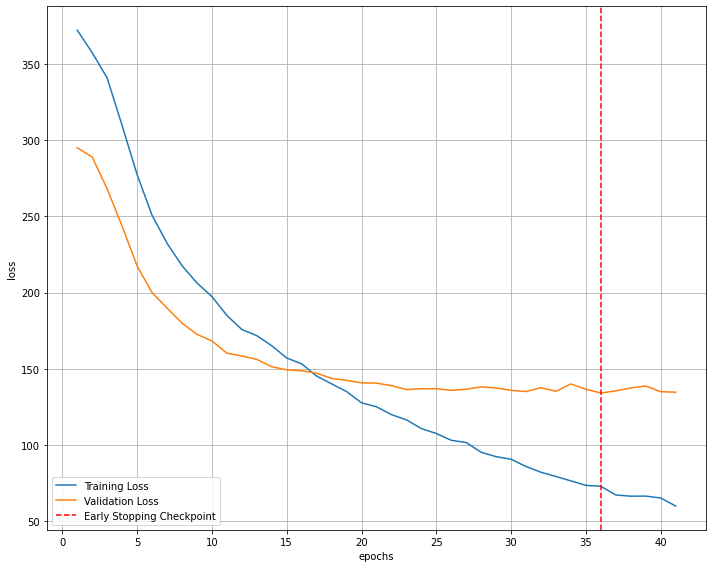

--------------- Fold:  1 ---------------------

              precision    recall  f1-score   support

           0       0.35      0.52      0.42        42
           1       0.54      0.47      0.50        15
           2       0.86      0.80      0.83        40
           3       0.86      0.86      0.86        21
           4       0.59      0.50      0.54        32
           5       0.89      0.93      0.91        27
           6       0.43      0.42      0.43        24
           7       0.73      0.73      0.73        11
           8       0.77      0.50      0.61        20
           9       0.75      0.82      0.78        50
          10       0.68      0.76      0.72        72
          11       0.40      0.18      0.25        11
          12       1.00      0.14      0.25         7
          13       0.29      0.28      0.28        40
          14       0.77      0.77      0.77        13
          15       0.50      0.20      0.29        10
          16       0.00      0.00

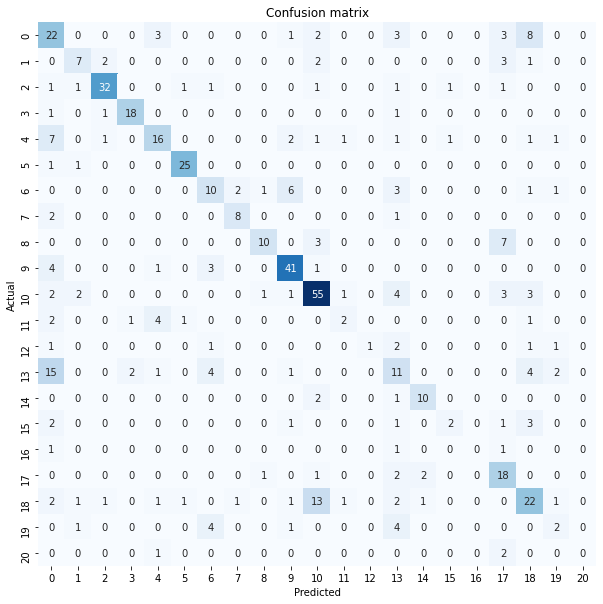


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  370.998556  | 294.477555 |   11.25   |   0.92   
Validation loss decreased (inf --> 294.477555).  Saving model ...
   2    |  357.651328  | 289.401693 |   11.25   |   0.93   
Validation loss decreased (294.477555 --> 289.401693).  Saving model ...
   3    |  343.189244  | 269.619325 |   20.78   |   0.94   
Validation loss decreased (289.401693 --> 269.619325).  Saving model ...
   4    |  310.054547  | 238.132931 |   29.84   |   0.89   
Validation loss decreased (269.619325 --> 238.132931).  Saving model ...
   5    |  275.934035  | 213.509367 |   38.41   |   0.89   
Validation loss decreased (238.132931 --> 213.509367).  Saving model ...
   6    |  250.291776  | 194.957194 |   41.83   |   0.89   
Validation loss decreased (213.509367 --> 194.957194).  Saving model ...

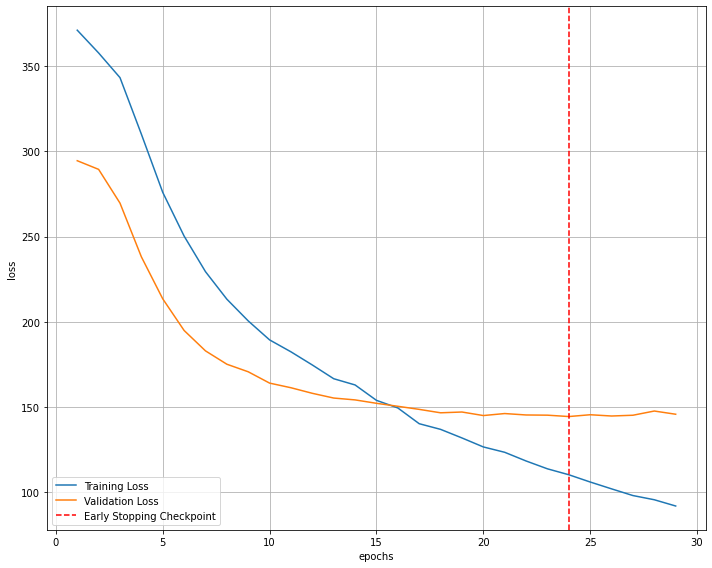

--------------- Fold:  2 ---------------------

              precision    recall  f1-score   support

           0       0.53      0.60      0.56        42
           1       0.23      0.20      0.21        15
           2       0.73      0.90      0.81        40
           3       0.56      0.70      0.62        20
           4       0.54      0.61      0.57        33
           5       0.88      0.82      0.85        28
           6       0.60      0.75      0.67        24
           7       0.71      0.45      0.56        11
           8       0.43      0.30      0.35        20
           9       0.81      0.84      0.82        50
          10       0.66      0.82      0.73        72
          11       1.00      0.36      0.53        11
          12       0.00      0.00      0.00         7
          13       0.39      0.50      0.44        40
          14       0.80      0.31      0.44        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

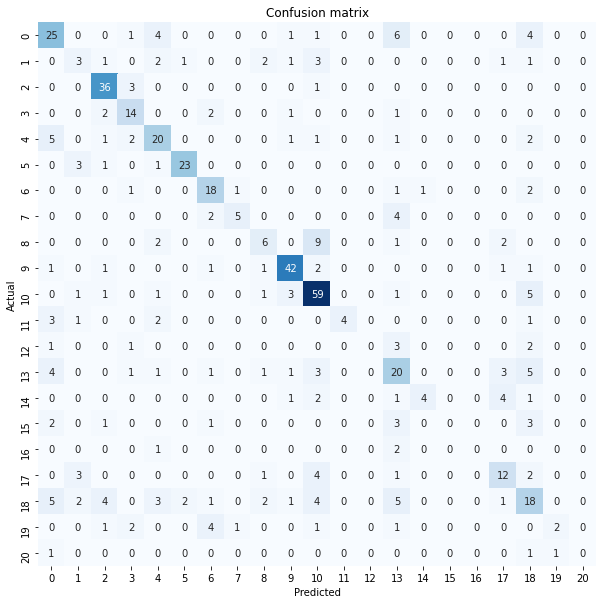


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  371.760688  | 294.126598 |   11.25   |   0.89   
Validation loss decreased (inf --> 294.126598).  Saving model ...
   2    |  358.319184  | 288.229330 |   11.25   |   0.88   
Validation loss decreased (294.126598 --> 288.229330).  Saving model ...
   3    |  343.014481  | 266.595724 |   18.28   |   0.88   
Validation loss decreased (288.229330 --> 266.595724).  Saving model ...
   4    |  307.946217  | 232.634325 |   34.22   |   0.89   
Validation loss decreased (266.595724 --> 232.634325).  Saving model ...
   5    |  274.725980  | 207.275034 |   40.40   |   0.95   
Validation loss decreased (232.634325 --> 207.275034).  Saving model ...
   6    |  249.000384  | 190.602289 |   43.50   |   0.88   
Validation loss decreased (207.275034 --> 190.602289).  Saving model ...

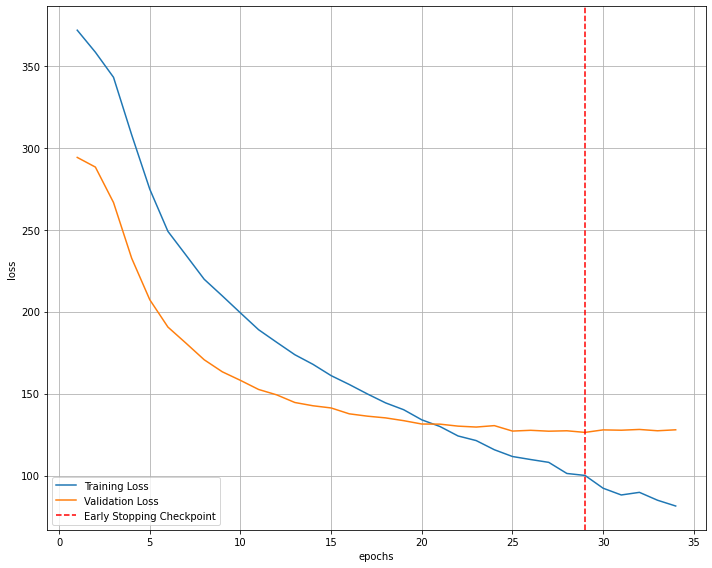

--------------- Fold:  3 ---------------------

              precision    recall  f1-score   support

           0       0.39      0.48      0.43        42
           1       0.54      0.50      0.52        14
           2       0.76      0.95      0.84        40
           3       0.71      0.60      0.65        20
           4       0.51      0.64      0.57        33
           5       0.83      0.89      0.86        28
           6       0.72      0.88      0.79        24
           7       0.78      0.64      0.70        11
           8       0.80      0.60      0.69        20
           9       0.81      0.76      0.78        50
          10       0.74      0.86      0.79        72
          11       0.50      0.09      0.15        11
          12       0.00      0.00      0.00         7
          13       0.26      0.25      0.26        40
          14       0.60      0.46      0.52        13
          15       0.00      0.00      0.00        10
          16       1.00      0.33

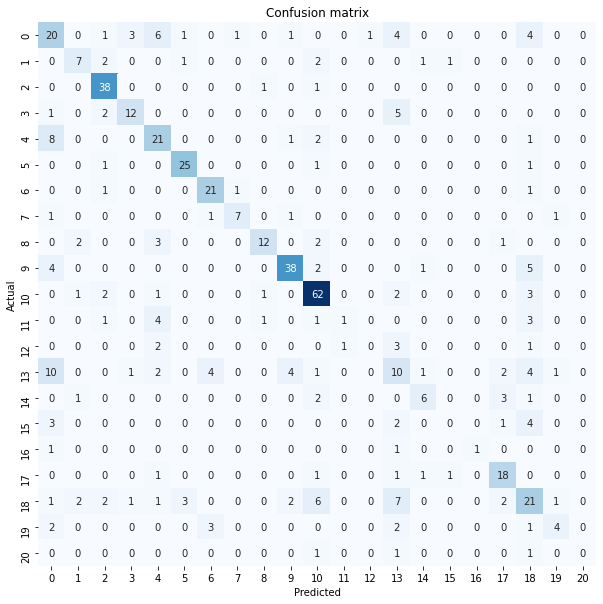


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  370.164802  | 293.458569 |   11.25   |   0.88   
Validation loss decreased (inf --> 293.458569).  Saving model ...
   2    |  355.350245  | 285.130830 |   12.03   |   0.88   
Validation loss decreased (293.458569 --> 285.130830).  Saving model ...
   3    |  334.777839  | 255.453597 |   27.34   |   0.94   
Validation loss decreased (285.130830 --> 255.453597).  Saving model ...
   4    |  295.194420  | 222.309658 |   33.12   |   0.90   
Validation loss decreased (255.453597 --> 222.309658).  Saving model ...
   5    |  264.211541  | 199.367719 |   41.49   |   0.89   
Validation loss decreased (222.309658 --> 199.367719).  Saving model ...
   6    |  243.065791  | 184.006972 |   48.92   |   0.88   
Validation loss decreased (199.367719 --> 184.006972).  Saving model ...

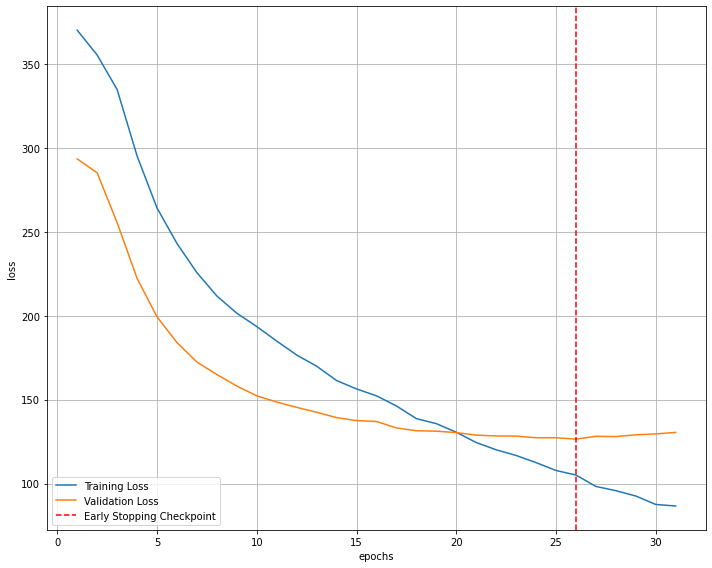

--------------- Fold:  4 ---------------------

              precision    recall  f1-score   support

           0       0.45      0.60      0.52        42
           1       0.62      0.36      0.45        14
           2       0.79      0.85      0.82        40
           3       0.68      0.75      0.71        20
           4       0.53      0.58      0.55        33
           5       0.80      1.00      0.89        28
           6       0.62      0.65      0.64        23
           7       0.62      0.45      0.53        11
           8       0.68      0.75      0.71        20
           9       0.79      0.88      0.83        50
          10       0.68      0.81      0.74        72
          11       0.83      0.45      0.59        11
          12       0.00      0.00      0.00         7
          13       0.61      0.50      0.55        40
          14       0.75      0.64      0.69        14
          15       1.00      0.10      0.18        10
          16       0.00      0.00

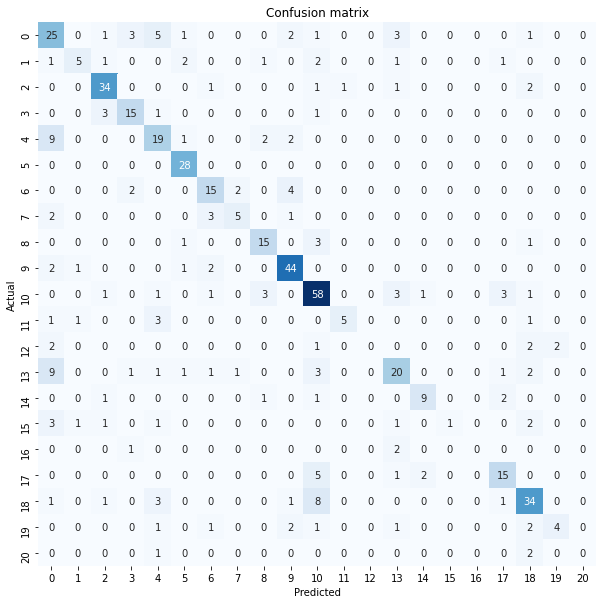


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  371.661969  | 293.865137 |   11.25   |   0.89   
Validation loss decreased (inf --> 293.865137).  Saving model ...
   2    |  356.288582  | 287.916139 |   11.25   |   0.88   
Validation loss decreased (293.865137 --> 287.916139).  Saving model ...
   3    |  342.745944  | 266.450309 |   23.44   |   0.96   
Validation loss decreased (287.916139 --> 266.450309).  Saving model ...
   4    |  308.297537  | 231.951620 |   32.66   |   0.91   
Validation loss decreased (266.450309 --> 231.951620).  Saving model ...
   5    |  273.976010  | 209.557502 |   35.31   |   0.90   
Validation loss decreased (231.951620 --> 209.557502).  Saving model ...
   6    |  253.921135  | 197.257941 |   38.28   |   0.93   
Validation loss decreased (209.557502 --> 197.257941).  Saving model ...

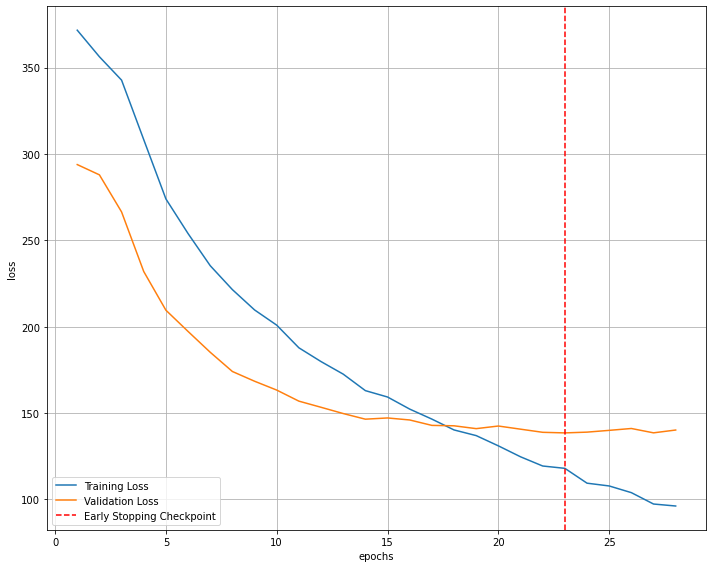

--------------- Fold:  5 ---------------------

              precision    recall  f1-score   support

           0       0.40      0.45      0.43        42
           1       0.43      0.21      0.29        14
           2       0.73      0.82      0.78        40
           3       0.79      0.75      0.77        20
           4       0.64      0.76      0.69        33
           5       0.71      0.89      0.79        27
           6       0.68      0.79      0.73        24
           7       0.78      0.64      0.70        11
           8       0.75      0.60      0.67        20
           9       0.76      0.86      0.81        51
          10       0.62      0.86      0.72        72
          11       1.00      0.18      0.31        11
          12       1.00      0.14      0.25         7
          13       0.46      0.47      0.47        40
          14       1.00      0.43      0.60        14
          15       0.00      0.00      0.00        10
          16       0.00      0.00

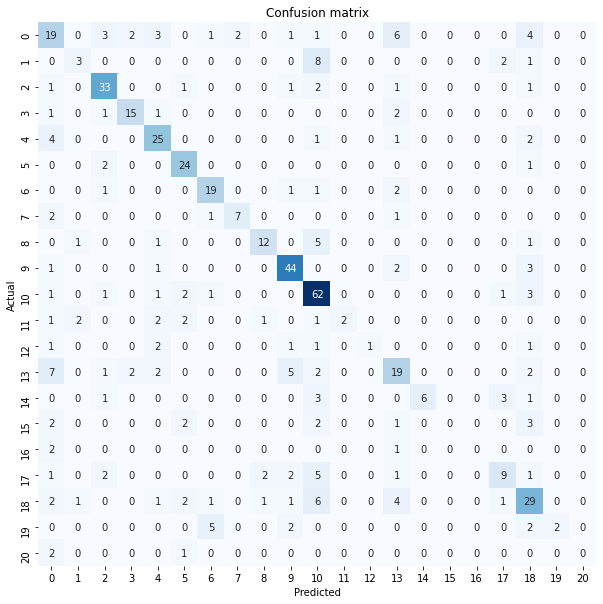


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  370.899449  | 293.682058 |   11.25   |   0.91   
Validation loss decreased (inf --> 293.682058).  Saving model ...
   2    |  357.031692  | 286.028260 |   13.28   |   0.88   
Validation loss decreased (293.682058 --> 286.028260).  Saving model ...
   3    |  337.326377  | 259.169239 |   25.78   |   0.89   
Validation loss decreased (286.028260 --> 259.169239).  Saving model ...
   4    |  302.018634  | 226.890552 |   32.81   |   0.91   
Validation loss decreased (259.169239 --> 226.890552).  Saving model ...
   5    |  271.931347  | 200.979137 |   42.38   |   0.89   
Validation loss decreased (226.890552 --> 200.979137).  Saving model ...
   6    |  250.223733  | 184.953009 |   47.82   |   0.89   
Validation loss decreased (200.979137 --> 184.953009).  Saving model ...

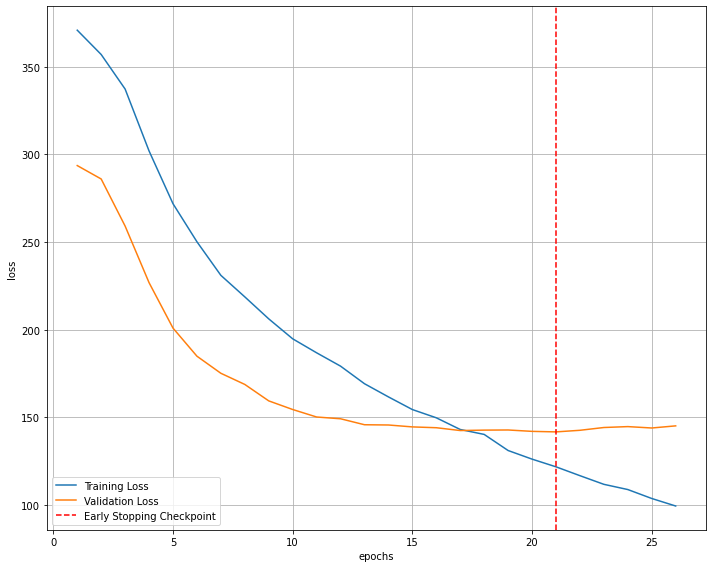

--------------- Fold:  6 ---------------------

              precision    recall  f1-score   support

           0       0.35      0.40      0.38        42
           1       0.36      0.36      0.36        14
           2       0.78      0.88      0.83        41
           3       0.62      0.90      0.73        20
           4       0.53      0.50      0.52        32
           5       0.81      0.78      0.79        27
           6       0.67      0.83      0.74        24
           7       0.55      0.55      0.55        11
           8       0.61      0.90      0.73        21
           9       0.72      0.80      0.76        51
          10       0.75      0.76      0.76        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.36      0.21      0.26        39
          14       0.77      0.77      0.77        13
          15       0.00      0.00      0.00        11
          16       0.00      0.00

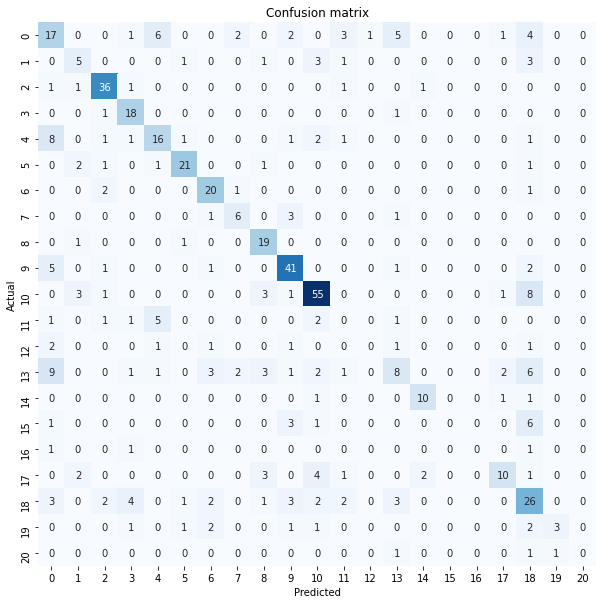


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  368.858909  | 293.050381 |   11.25   |   0.92   
Validation loss decreased (inf --> 293.050381).  Saving model ...
   2    |  357.000129  | 285.938537 |   11.41   |   0.88   
Validation loss decreased (293.050381 --> 285.938537).  Saving model ...
   3    |  340.000231  | 260.151928 |   25.00   |   0.89   
Validation loss decreased (285.938537 --> 260.151928).  Saving model ...
   4    |  304.837124  | 222.481437 |   34.04   |   0.91   
Validation loss decreased (260.151928 --> 222.481437).  Saving model ...
   5    |  270.128873  | 194.188660 |   43.83   |   0.92   
Validation loss decreased (222.481437 --> 194.188660).  Saving model ...
   6    |  246.381878  | 178.185334 |   51.68   |   0.90   
Validation loss decreased (194.188660 --> 178.185334).  Saving model ...

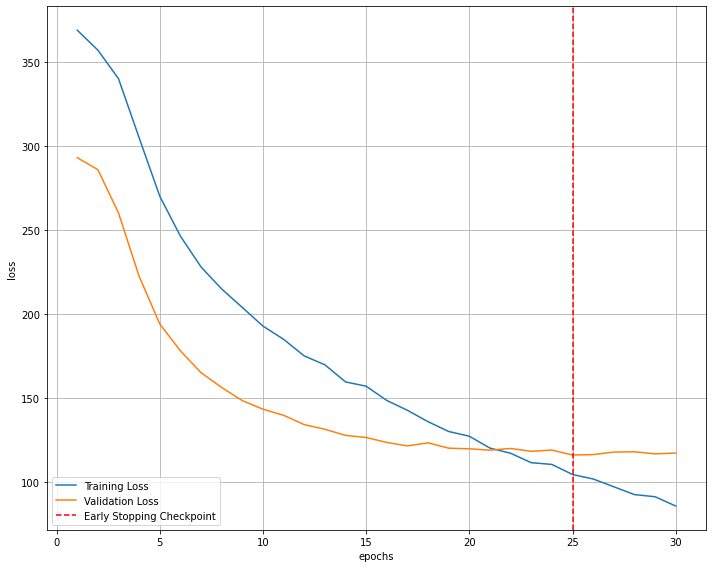

--------------- Fold:  7 ---------------------

              precision    recall  f1-score   support

           0       0.40      0.52      0.45        42
           1       0.50      0.29      0.36        14
           2       0.88      0.88      0.88        41
           3       0.70      0.76      0.73        21
           4       0.44      0.44      0.44        32
           5       0.73      0.89      0.80        27
           6       0.67      0.67      0.67        24
           7       0.43      0.30      0.35        10
           8       0.58      0.86      0.69        21
           9       0.82      0.88      0.85        51
          10       0.81      0.89      0.85        72
          11       0.33      0.10      0.15        10
          12       0.67      0.25      0.36         8
          13       0.55      0.45      0.49        40
          14       0.69      0.69      0.69        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

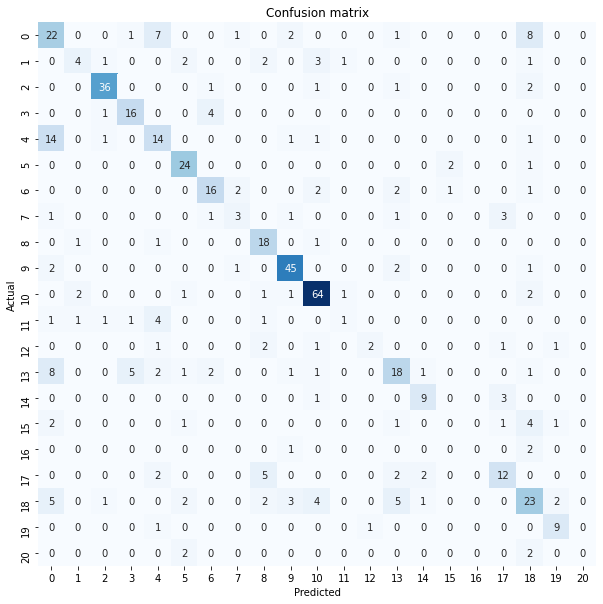


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  371.132456  | 292.606106 |   11.25   |   0.89   
Validation loss decreased (inf --> 292.606106).  Saving model ...
   2    |  357.259748  | 284.789497 |   17.97   |   0.89   
Validation loss decreased (292.606106 --> 284.789497).  Saving model ...
   3    |  337.588254  | 257.017402 |   26.88   |   0.88   
Validation loss decreased (284.789497 --> 257.017402).  Saving model ...
   4    |  304.997869  | 226.928845 |   35.16   |   0.88   
Validation loss decreased (257.017402 --> 226.928845).  Saving model ...
   5    |  273.629492  | 201.356154 |   37.81   |   0.93   
Validation loss decreased (226.928845 --> 201.356154).  Saving model ...
   6    |  249.493792  | 183.615353 |   43.65   |   0.88   
Validation loss decreased (201.356154 --> 183.615353).  Saving model ...

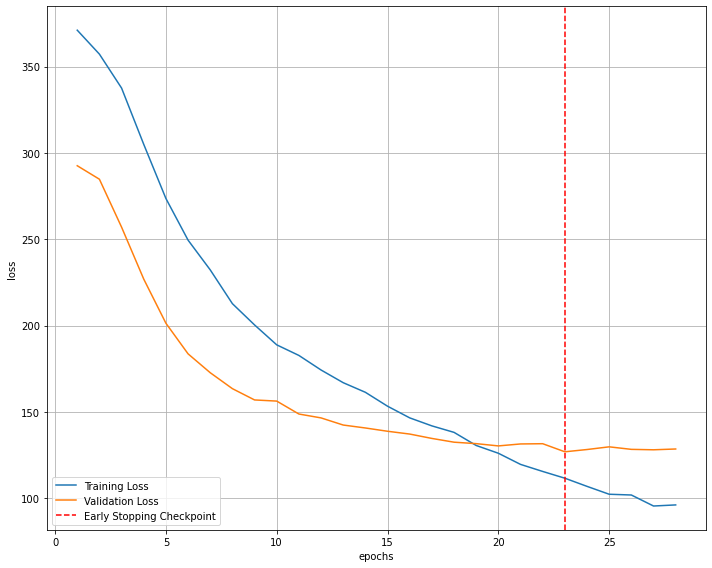

--------------- Fold:  8 ---------------------

              precision    recall  f1-score   support

           0       0.46      0.43      0.44        42
           1       0.33      0.07      0.12        14
           2       0.89      0.95      0.92        41
           3       0.64      0.86      0.73        21
           4       0.58      0.66      0.62        32
           5       0.84      0.96      0.90        27
           6       0.58      0.46      0.51        24
           7       0.56      0.50      0.53        10
           8       0.75      0.71      0.73        21
           9       0.78      0.82      0.80        51
          10       0.77      0.79      0.78        72
          11       0.50      0.30      0.37        10
          12       0.00      0.00      0.00         8
          13       0.38      0.60      0.47        40
          14       0.64      0.54      0.58        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

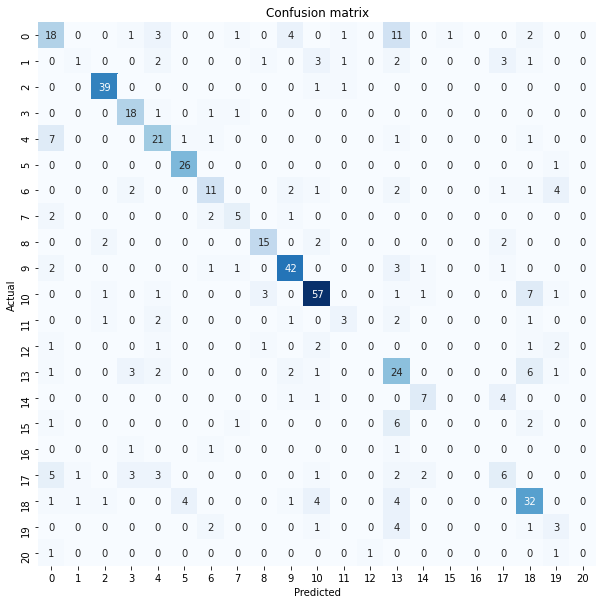


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  371.594597  | 292.660730 |   11.25   |   0.92   
Validation loss decreased (inf --> 292.660730).  Saving model ...
   2    |  357.708391  | 286.995447 |   11.25   |   0.89   
Validation loss decreased (292.660730 --> 286.995447).  Saving model ...
   3    |  343.605005  | 265.550421 |   21.41   |   0.90   
Validation loss decreased (286.995447 --> 265.550421).  Saving model ...
   4    |  313.180799  | 233.689412 |   32.19   |   0.93   
Validation loss decreased (265.550421 --> 233.689412).  Saving model ...
   5    |  281.614928  | 207.604396 |   34.38   |   0.88   
Validation loss decreased (233.689412 --> 207.604396).  Saving model ...
   6    |  258.183751  | 188.860817 |   37.81   |   0.93   
Validation loss decreased (207.604396 --> 188.860817).  Saving model ...

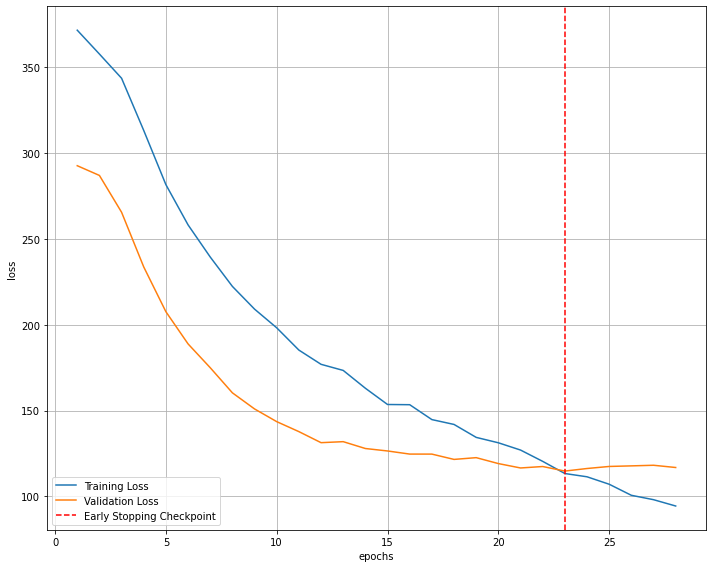

--------------- Fold:  9 ---------------------

              precision    recall  f1-score   support

           0       0.46      0.45      0.46        42
           1       0.38      0.21      0.27        14
           2       0.86      0.75      0.80        40
           3       0.76      0.90      0.83        21
           4       0.54      0.66      0.59        32
           5       0.56      0.85      0.68        27
           6       0.61      0.92      0.73        24
           7       0.57      0.40      0.47        10
           8       0.70      0.70      0.70        20
           9       0.81      0.90      0.85        51
          10       0.77      0.81      0.79        72
          11       0.40      0.20      0.27        10
          12       0.00      0.00      0.00         8
          13       0.43      0.25      0.32        40
          14       0.58      0.54      0.56        13
          15       0.22      0.20      0.21        10
          16       0.00      0.00

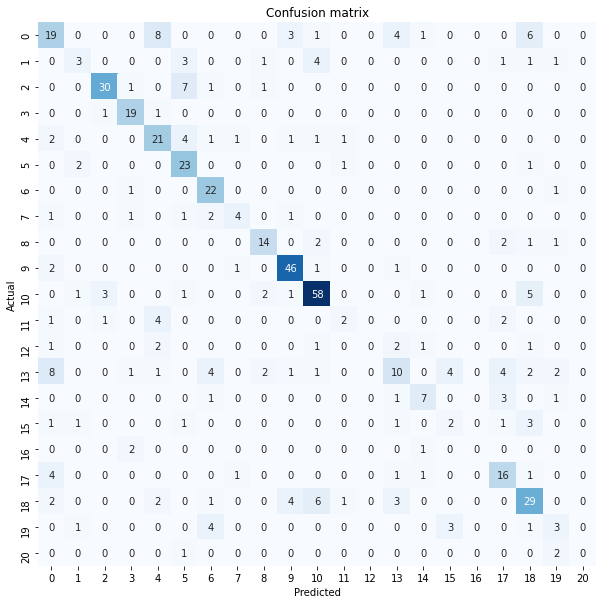


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  370.033632  | 292.805194 |   11.25   |   0.88   
Validation loss decreased (inf --> 292.805194).  Saving model ...
   2    |  357.221700  | 286.288723 |   16.25   |   0.89   
Validation loss decreased (292.805194 --> 286.288723).  Saving model ...
   3    |  342.319816  | 264.463573 |   23.07   |   0.93   
Validation loss decreased (286.288723 --> 264.463573).  Saving model ...
   4    |  309.055408  | 233.550176 |   36.51   |   0.88   
Validation loss decreased (264.463573 --> 233.550176).  Saving model ...
   5    |  278.568299  | 208.471458 |   43.23   |   0.90   
Validation loss decreased (233.550176 --> 208.471458).  Saving model ...
   6    |  251.685094  | 189.782401 |   47.86   |   0.90   
Validation loss decreased (208.471458 --> 189.782401).  Saving model ...

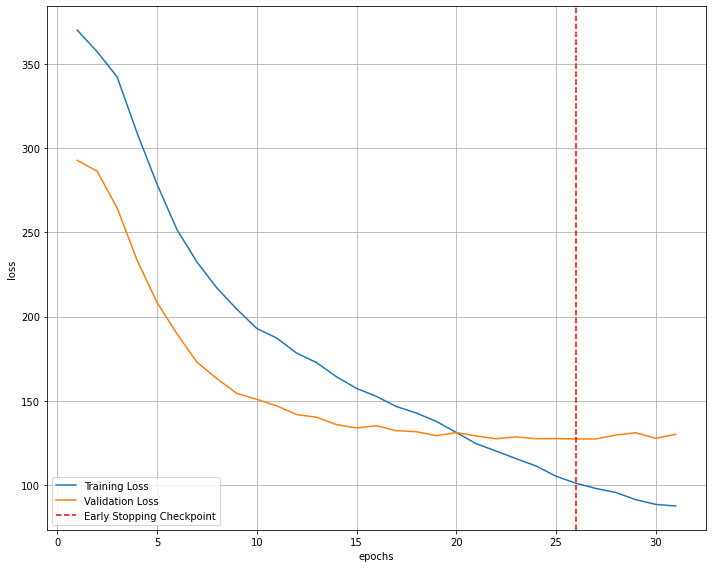

--------------- Fold: 10 ---------------------

              precision    recall  f1-score   support

           0       0.71      0.52      0.60        42
           1       0.22      0.13      0.17        15
           2       0.78      0.90      0.84        40
           3       0.86      0.86      0.86        21
           4       0.61      0.62      0.62        32
           5       0.71      0.89      0.79        27
           6       0.50      0.92      0.65        24
           7       0.67      0.55      0.60        11
           8       0.52      0.80      0.63        20
           9       0.79      0.88      0.83        50
          10       0.71      0.61      0.66        72
          11       0.14      0.09      0.11        11
          12       0.00      0.00      0.00         7
          13       0.44      0.62      0.52        40
          14       0.89      0.62      0.73        13
          15       1.00      0.10      0.18        10
          16       0.00      0.00

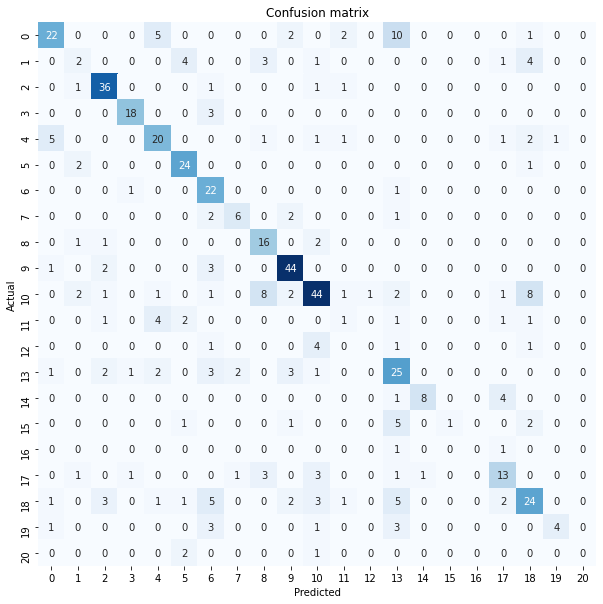

In [80]:
####### Setting up Cross-Validation #####
y=np.array(classes)
documents=np.array(documents)
kfold = StratifiedKFold(n_splits=nfold).split(documents, y)

####### Define Variables for Metrics #####
accuracys = []
scores= []
metriche = np.zeros((nfold,4,output_dim))

####### Cross-Validation Loop ############

for k, (train_ids, test_ids) in enumerate(kfold):
    
    padded_sentences_train,lenght_train = pad_text(documents[train_ids], seq_length = int(quant))
    padded_sentences_test,lenght_test = pad_text(documents[test_ids], seq_length = int(quant))
    
    encoded_sentences_train = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_train])
    encoded_sentences_test  = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_test])
    
    print("train:",encoded_sentences_train.shape,"len:",lenght_train.size, "train_y:",y[train_ids].size)
    print("test:",encoded_sentences_test.shape,"len:",lenght_test.size)
    
    
    
    train_loader, val_loader=create_data_loader(encoded_sentences_train,lenght_train,
                                                encoded_sentences_test,lenght_test,
                                                y[train_ids],y[test_ids],batch_size)
    

  ####### Instantiate model ############  
    model = ClassificationCNN(
                        pretrained_embedding=embeddings, 
                        n_output=output_dim,
                        filter_sizes=filter_sizes,
                        dropout=dropout_pc,
                        n_filters=number_of_filters)
    
    model=model.double()

    loss_fn = nn.CrossEntropyLoss(reduction='sum').to(DEVICE)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=lr,weight_decay=0.01)
    model.to(DEVICE)
    model=train(model,optimizer,loss_fn,train_loader,val_loader,patience,n_epochs)
    
    ####### Compute Accuracy ##########
    y_pred=pytorch_predict(model,val_loader)
    
    y_true=y[test_ids]
    
    target_names=np.unique(y[train_ids])
    accuracys.append(metrics.accuracy_score(y_true, y_pred))

    ####### Compute Precision,Recall,F-Score ############
    score=precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, labels=target_names, average="weighted")
    scores.append(score[0:3])

    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    target_names = list(map(str,target_names))
    print(metrics.classification_report(y_true, y_pred, target_names=target_names))
    dizionario=metrics.classification_report(y_true, y_pred, target_names=target_names,output_dict=True)
    for k_d,(m_id, m_info) in enumerate(dizionario.items()):
        if k_d<output_dim:
            for j_d,key in enumerate(m_info):
                metriche[k,j_d,k_d]=m_info[key]
        else:
            break

     ## Plot confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cbar=False,cmap=plt.cm.Blues)
    ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=target_names, 
           yticklabels=target_names, title="Confusion matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print()

arr = np.array(scores)

## Results Output

In [81]:
print("Overall results of the cross-validation procedure")
print()
print("Level 1")
print()

print('\nCV accuracy: %.2f +/- %.2f max: %.2f' % (np.mean(accuracys)*100, np.std(accuracys)*100,np.max(accuracys)*100))
print('\nCV precision: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,0])*100, np.std(arr[:,0])*100,np.max(arr[:,0])*100))
print('\nCV recall: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,1])*100, np.std(arr[:,1])*100,np.max(arr[:,1])*100))
print('\nCV f1: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,2])*100, np.std(arr[:,2])*100,np.max(arr[:,2])*100))

print()
print("Level 2")
print()
print(f"{'Class':^7} | {'precision':^9}{'':^6} | {'recall':^10}{'':^5} | {'f1-measure':^6}{'':^5} | {'support':^9}")
for i in range(output_dim):
    print(f"{i :^7} | {np.mean(metriche[:,0,i])*100:^5.2f}  +/-{np.std(metriche[:,0,i])*100:^6.2f} | {np.mean(metriche[:,1,i])*100:^5.2f} +/-{np.std(metriche[:,1,i])*100:^6.2f} | {np.mean(metriche[:,2,i])*100:^5.2f} +/-{np.std(metriche[:,2,i])*100:^6.2f} | {np.mean(metriche[:,3,i]):^9.2f}")

Overall results of the cross-validation procedure

Level 1


CV accuracy: 62.17 +/- 2.28 max: 66.86

CV precision: 60.69 +/- 2.69 max: 65.99

CV recall: 62.17 +/- 2.28 max: 66.86

CV f1: 60.20 +/- 2.29 max: 65.04

Level 2

 Class  | precision       |   recall        | f1-measure      |  support 
   0    | 45.21  +/-10.09  | 49.76 +/- 6.25  | 46.90 +/- 6.61  |   42.00  
   1    | 41.49  +/-12.83  | 28.00 +/-13.24  | 32.51 +/-13.11  |   14.30  
   2    | 80.70  +/- 5.62  | 86.82 +/- 6.05  | 83.41 +/- 3.80  |   40.30  
   3    | 71.71  +/- 9.36  | 79.38 +/- 9.32  | 74.91 +/- 7.61  |   20.50  
   4    | 55.13  +/- 5.42  | 59.51 +/- 8.94  | 57.05 +/- 6.47  |   32.40  
   5    | 77.57  +/- 9.63  | 88.99 +/- 6.12  | 82.51 +/- 6.71  |   27.30  
   6    | 60.86  +/- 8.26  | 72.77 +/-16.96  | 65.53 +/-10.58  |   23.90  
   7    | 63.90  +/-10.84  | 52.00 +/-11.96  | 57.04 +/-11.00  |   10.70  
   8    | 65.89  +/-11.51  | 67.26 +/-17.08  | 65.08 +/-10.67  |   20.30  
   9    | 78.14  +/- 3.03  |